In [1]:
%load_ext autoreload
%autoreload 2



import experiment_code.neural.draw_utils.plot_experiments as drawer
import mlflow
import ast

MLFLOW_PATH = "./../mlruns"
mlflow.set_tracking_uri(MLFLOW_PATH)

drawer.DURATION_KEY = 'pull_rew.eval_rez.duration'

drawer.METRIC_KEYS = [
        'alg_name',
        "pulled_arm",
        'pull_rew.confidence_bound',
        'pull_rew.value',

        'pull_rew.eval_rez.loss',
        'pull_rew.eval_rez.duration',
        'pull_rew.eval_rez.accuracy',

        'test_rew.loss',
        'test_rew.duration',
        'test_rew.accuracy'
    ]


def process_run(run_id, client, n_arms, ARM_KEY):
    run_res = []
    for key in drawer.METRIC_KEYS:
        metric_h = client.get_metric_history(run_id, key=key)
        
        T = len(metric_h)
        if len(run_res) < T:
            run_res = [{} for i in range(T)]

        for i, elem in enumerate(metric_h):                
            run_res[i][key] = int(elem.value) if key == ARM_KEY else elem.value
                
    return run_res

def get_best_alg(run_res, budget = -1):
    return sorted(run_res[:budget], key = lambda x: x["pull_rew.eval_rez.loss"])[0]

def get_runs_by_name(EXP_NAME, RUN_NAME_ST):
    experiment = mlflow.get_experiment_by_name(EXP_NAME)
    runs = mlflow.search_runs(experiment.experiment_id)

    filter_params = {}
    filter_params["RUN_NAME_ST"] = RUN_NAME_ST
    selected_runs = runs.apply(lambda x: drawer.runs_filter(x, filter_params), axis=1)

    run_ids = runs[selected_runs]['run_id'].values

#     # set client and process runs separately
    client = mlflow.MlflowClient()

#     # get experiment names
    run = client.get_run(run_ids[0])
    return run_ids, run, client

def get_hyperband():
    N_ARMS: int = 5
    EXP_NAME: str = "experiments_cycle_50"
    RUN_NAME_ST: str = "mab_train;Hyperband"
    

    run_ids, run, client = get_runs_by_name(EXP_NAME, RUN_NAME_ST)

    # get alg_names
    a = run.data.params["model_names_hash"]
    a = a[81:-1] if a.startswith("defaultdict") else a
    alg_names =  ast.literal_eval(a)
    alg_names = {v: k for k, v in alg_names.items()}

    assert len(alg_names) == N_ARMS

    run_results = [process_run(run_id, client, N_ARMS, "alg_name") for run_id in run_ids]

    return run_results, alg_names

def get_others(RUN_NAME_ST, EXP_NAME: str = "experiments_cycle_50"):
    N_ARMS: int = 5

    run_ids, run, client = get_runs_by_name(EXP_NAME, RUN_NAME_ST)
# get experiments
    experiment = mlflow.get_experiment_by_name(EXP_NAME)
    runs = mlflow.search_runs(experiment.experiment_id)

    alg_names =  ast.literal_eval(run.data.params["alg_names"])

    assert len(alg_names) == N_ARMS

    run_results = [process_run(run_id, client, N_ARMS, "pulled_arm") for run_id in run_ids]

    return run_results, alg_names

In [2]:
BUDGET = 20

In [3]:

run_names = ["mab_train;UCB_1-", "mab_train;SuccessiveHalving-",]

hyperband_res = get_hyperband()

others_res = [get_others(r_st,) for r_st in run_names]

In [4]:
hyperband_bests = [get_best_alg(run_res, budget=BUDGET) for run_res in hyperband_res[0]]
hyperband_bests = [(hyperband_res[1][hr["alg_name"]], hr["pull_rew.eval_rez.loss"]) for hr in hyperband_bests]


def get_other_res(other_res):
    alg_names = other_res[1]
    alg_res = other_res[0]
    alg_bests = [get_best_alg(res,budget=BUDGET) for res in alg_res]
    best_alg = [(alg_names[ab["pulled_arm"]], ab['pull_rew.eval_rez.loss']) for ab in alg_bests]
    return best_alg

others_rank = [get_other_res(res) for res in others_res]

result = {"hyperband": hyperband_bests, **{rn[10:-1]: rr for rn, rr in zip(run_names, others_rank)}}
result

{'hyperband': [('ResNet18', 1.1869987111091613),
  ('ShallowMLP', 1.5725349445343018),
  ('ResNet18', 1.2199283675193786),
  ('ResNet18', 1.2419414140701295),
  ('ResNet18', 1.1785548318862915),
  ('ResNet18', 1.1232944526672364),
  ('ShallowMLP', 1.601429641723633),
  ('ResNet18', 1.2065040477752687),
  ('ResNet18', 1.512155326652527),
  ('ResNet18', 1.2483807562828064)],
 'UCB_1': [('ResNet18', 1.145894293785095),
  ('ResNet18', 1.3039292518615722),
  ('ResNet18', 1.352375319290161),
  ('ResNet18', 1.2567324659347534),
  ('ResNet18', 1.175838740825653),
  ('ResNet18', 1.2181252029418945),
  ('ResNet18', 1.4994365577697755),
  ('ResNet18', 1.307994221305847)],
 'SuccessiveHalving': [('ResNet18', 1.4317563526153565),
  ('ResNet18', 1.513706651687622),
  ('ResNet18', 1.5332299240112304),
  ('ResNet18', 1.5124147087097168),
  ('ResNet18', 1.5180881452560424),
  ('ResNet18', 1.5732503231048585),
  ('ResNet18', 1.4964283843994142),
  ('ResNet18', 1.6148534713745117),
  ('ResNet18', 1.48581

In [5]:
result = {"hyperband": hyperband_bests, **{rn[10:-1]: rr for rn, rr in zip(run_names, others_rank)}}
result

{'hyperband': [('ResNet18', 1.1869987111091613),
  ('ShallowMLP', 1.5725349445343018),
  ('ResNet18', 1.2199283675193786),
  ('ResNet18', 1.2419414140701295),
  ('ResNet18', 1.1785548318862915),
  ('ResNet18', 1.1232944526672364),
  ('ShallowMLP', 1.601429641723633),
  ('ResNet18', 1.2065040477752687),
  ('ResNet18', 1.512155326652527),
  ('ResNet18', 1.2483807562828064)],
 'UCB_1': [('ResNet18', 1.145894293785095),
  ('ResNet18', 1.3039292518615722),
  ('ResNet18', 1.352375319290161),
  ('ResNet18', 1.2567324659347534),
  ('ResNet18', 1.175838740825653),
  ('ResNet18', 1.2181252029418945),
  ('ResNet18', 1.4994365577697755),
  ('ResNet18', 1.307994221305847)],
 'SuccessiveHalving': [('ResNet18', 1.4317563526153565),
  ('ResNet18', 1.513706651687622),
  ('ResNet18', 1.5332299240112304),
  ('ResNet18', 1.5124147087097168),
  ('ResNet18', 1.5180881452560424),
  ('ResNet18', 1.5732503231048585),
  ('ResNet18', 1.4964283843994142),
  ('ResNet18', 1.6148534713745117),
  ('ResNet18', 1.48581

In [6]:
losses = [] 
labels = []

for k, v in result.items():
    labels.append(k)
    losses.append([elem[1] for elem in v])


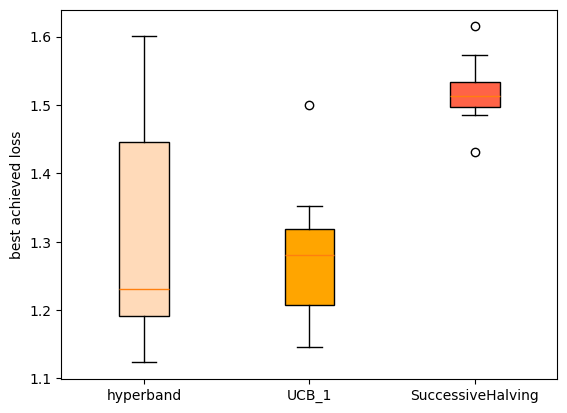

In [7]:
import matplotlib.pyplot as plt
colors = ['peachpuff', 'orange', 'tomato', "green", "black"]

fig, ax = plt.subplots()
ax.set_ylabel('best achieved loss')

bplot = ax.boxplot(losses,
                   tick_labels=labels,
                   patch_artist=True)  # will be used to label x-ticks

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

In [8]:
from collections import defaultdict
import numpy as np

budgets = np.arange(5, 50, 5)

res = defaultdict(list)
for BUDGET in budgets:
    hyperband_bests = [get_best_alg(run_res, budget=BUDGET) for run_res in hyperband_res[0]]
    hyperband_bests = [(hyperband_res[1][hr["alg_name"]], hr["pull_rew.eval_rez.loss"]) for hr in hyperband_bests]


    def get_other_res(other_res):
        alg_names = other_res[1]
        alg_res = other_res[0]
        alg_bests = [get_best_alg(res,budget=BUDGET) for res in alg_res]
        best_alg = [(alg_names[ab["pulled_arm"]], ab['pull_rew.eval_rez.loss']) for ab in alg_bests]
        return best_alg

    others_rank = [get_other_res(res) for res in others_res]

    result = {"hyperband": hyperband_bests, **{rn[10:-1]: rr for rn, rr in zip(run_names, others_rank)}}
    for k, v in result.items():
        res[k].append(np.mean([(a[0] == "ResNet18") for a in v]))

    

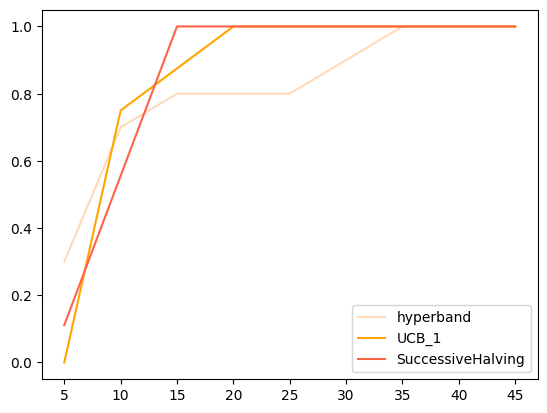

In [9]:
colors = ['peachpuff', 'orange', 'tomato', "green", "black"]
for color, (k, v) in zip(colors, res.items()):
    plt.plot(budgets, v, label = k, color = color)
plt.legend()

regret

In [10]:
def get_loss(run_results):
    losses = [[r["pull_rew.eval_rez.loss"] for r in res ]  for res in run_results]
    losses = np.array(losses).mean(0).cumsum(0)
    return  losses

regret = {"Hyperband": get_loss(hyperband_res[0]), **{rn[10:-1]: get_loss(rr[0]) for rn, rr in zip(run_names, others_res)}}

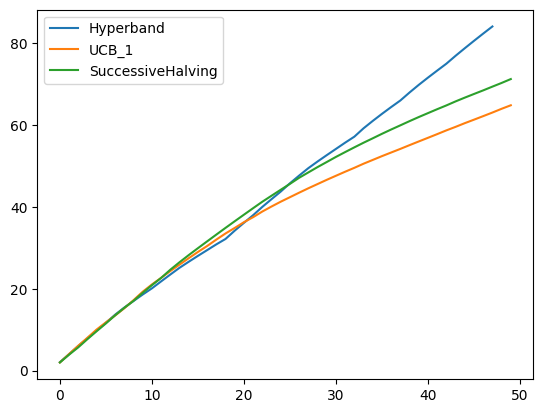

In [11]:
for k, v in regret.items():
    plt.plot(v, label = k)
plt.legend()